In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [2]:
%%html
<style>
div.float-bar-whh {
    z-index: 10;
    position: fixed;
    bottom: 5px;
    width: 540px;
    left: 50%;
    right: 50%;
    padding-right: 0px;
    padding-left: 0px;
    margin-left: -270px;
    background: #333;
    opacity: 0.7;
    box-shadow: 0 0 2px 0px black;
}
span.new-name-whh {
    height: 100%;
    line-height: 1em;
    margin: 16px 16px 16px 16px;
    border: none;
    font-size: 146.5%;
    color: white;
    text-overflow: ellipsis;
    overflow: hidden;
    white-space: nowrap;
    border-radius: 2px;
    opacity: 1;
}
</style>

<div class="float-bar-whh" style="display:block;">
    <center><span class="new-name-whh">D&P - accounting and auditing</span></center>
</div>

# Analysize variables.

In [3]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [4]:
# Get unique values for each variable.
empl_file = r"../deloitte_pwc.csv"

unique_values = []
for i in range(33):
    unique_values.append(set())
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        for i in range(33):
            unique_values[i].add(line[i])
for idx, values in enumerate(unique_values):
    print("[Column {}] ".format(idx)+str(len(values)))
        

[Column 0] 1095185
[Column 1] 84
[Column 2] 3
[Column 3] 45
[Column 4] 390501
[Column 5] 45
[Column 6] 390503
[Column 7] 16127
[Column 8] 258
[Column 9] 8
[Column 10] 2
[Column 11] 849
[Column 12] 3
[Column 13] 763
[Column 14] 3
[Column 15] 2
[Column 16] 3246
[Column 17] 2640332
[Column 18] 865
[Column 19] 1767657
[Column 20] 1557541
[Column 21] 10261
[Column 22] 309
[Column 23] 2
[Column 24] 204454
[Column 25] 739
[Column 26] 2
[Column 27] 8
[Column 28] 2
[Column 29] 1469
[Column 30] 68
[Column 31] 7835
[Column 32] 1003970


In [5]:
# One block to convert data to pd.DataFrame.
empl_file = r"../deloitte_pwc.csv"

entries_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        if idx == 20: # Control number of rows.
            break
        entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)
#entries_df.loc[lambda df:df[26]=='False',[17,18]]


In [6]:
# Get an example.
entry = samples_lst[2]
for i in range(len(entry)):
    print("[Column {}] ".format(i)+entry[i])

[Column 0] ed3c50a8-d2d3-3809-9d2a-0f53574560aa
[Column 1] 1980
[Column 2] 2
[Column 3] Accounting and Auditing
[Column 4] 0.9292892909340925
[Column 5] Industrial Management
[Column 6] 0.00825650305491638
[Column 7] Paris
[Column 8] France
[Column 9] 5
[Column 10] False
[Column 11] 2004-09-01
[Column 12] True
[Column 13] 2005-06-01
[Column 14] True
[Column 15] False
[Column 16] 273
[Column 17] Financial Controller Assistant,financial controller,assistant
[Column 18] ACCOUNTING
[Column 19] EADS Astrium
[Column 20] EADS Astrium
[Column 21] 
[Column 22] 
[Column 23] False
[Column 24] 
[Column 25] 
[Column 26] False
[Column 27] 
[Column 28] False
[Column 29] 
[Column 30] 
[Column 31] 
[Column 32] 1525765406000


# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the two companies (Deloitte and PwC, hereafter);
- `firing` if it changed its company from one of the two companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the two companies and not recogized as `firing`.

In [7]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*6 # "birth_year","gender","secondary_skill","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['',''] 
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,5,8,9,10]]
        if entry[6] is not None:
            self.profile[2] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the cu
        if entry[3]=="Accounting and Auditing" and entry[26] == "False"  and not sum([
            re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None for x in ["intern","internship","trainee"]
        ]):
            if self.employment[2] != entry[21]:
                if self.employment[2] in ['D','P']:
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*7
                if entry[21] in ['D','P']:
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]
                    self.employment[3] = entry[15]
                    self.employment[4] = entry[17]
                    self.employment[5] = entry[18]
                    self.employment[6] = 0
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
                self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [8]:
# Read, Identify & Aggregate.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        empl_change_this = career.read(entry)
        if empl_change_this != []:
            empl_changes_lst += empl_change_this

varlist = [
    "type","ticker","yrmth","birth","gender","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df


type ticker   yrmth birth gender                        skill2  \
0        hiring      P  200607  1980      2                                 
1       leaving      P  201210  1980      2                                 
2        hiring      D  200509  1978      2                                 
3       leaving      D  201307  1978      2                                 
4        hiring      D  200708  1983      2  Technical Product Management   
5       leaving      D  200808  1983      2  Technical Product Management   
6        hiring      P  201108  1986      2                                 
7        hiring      P  201207  1988      0                                 
8       leaving      P  201603  1988      0                                 
9        hiring      P  200008  1974      2             Middle Management   
10      leaving      P  200306  1974      2             Middle Management   
11       hiring      D  201206  1993      2                                 
12      leaving      D  201306  1993      2                                 
13       hiring      D  200910  2000      0                                 
14      leaving      D  201502  2000      0                                 
15       hiring      D  201209  1986      0          Business Development   
16      leaving      D  201404  1986      0          Business Development   
17       hiring      D  201200  1980      2                                 
18      leaving      D  201300  1980      2                                 
19       hiring      P  200801  1979      1                                 
20      leaving      P  201304  1979      1                                 
21       hiring      D  201309  1980      1                                 
22       hiring      P  201710  1989      1                Administration   
23       hiring      D  200912  2000      2                                 
24      leaving      D  201511  2000      2                                 
25       hiring      P  200309  1976      2          Business Development   
26      leaving      P  200612  1976      2          Business Development   
27       hiring      P  201412  1988      1                         Legal   
28       firing      P  201701  1988      1                         Legal   
29       hiring      P  199709  1965      1     Video and Film Production   
...         ...    ...     ...   ...    ...                           ...   
239224  leaving      D  201209  1985      2                                 
239225   hiring      P  201411  1991      2                                 
239226   hiring      D  201207  1985      1                                 
239227   hiring      D  201712  1988      1          Business Development   
239228  leaving      D  201802  1988      1          Business Development   
239229   hiring      D  201410  1982      1                                 
239230   hiring      D  200510  1972      1                                 
239231  leaving      D  201207  1972      1                                 
239232   hiring      D  199502  1976      2                                 
239233  leaving      D  201409  1976      2                                 
239234   hiring      D  201406  1984      1           Banking and Finance   
239235  leaving      D  201603  1984      1           Banking and Finance   
239236   hiring      D  201402  1982      1          Business Development   
239237  leaving      D  201510  1982      1          Business Development   
239238   hiring      D  201605  1982      1          Business Development   
239239   hiring      D  197109  1944      2      Human Resources (Senior)   
239240  leaving      D  197501  1944      2      Human Resources (Senior)   
239241   hiring      D  200902  1987      0      Human Resources (Junior)   
239242  leaving      D  200904  1987      0      Human Resources (Junior)   
239243   hiring      D  200607  1967      2           Banking and Finance   
239244 

A block prepared for counting annual employment.

In [9]:
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
res_dict = {"D":Counter([]),"P":Counter([])}
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        if (
            entry[21] in ['D','P'] and entry[3]=="Accounting and Auditing" and entry[26] == "False"
            and not sum([
                re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ")is not None for x in ["intern","internship","trainee","student","summer"]
            ])
        ):
            if entry[11] != "None" and (entry[13] != "None" or entry[15] == "True"):
                res_dict[entry[21]] += Counter(
                    range(
                        pd.to_datetime(entry[11]).year,
                        pd.to_datetime(entry[13]).year if entry[13]!="None" else 2019
                    )
                )

empl_by_years = pd.DataFrame(res_dict).fillna(0).unstack().reset_index()
empl_by_years.columns = ["ticker", "year", "employment"]


# Summarize and plot.

In [10]:
# Styles for the four groups: ('ticker': 'D','P') x ('firing', 'hiring','leaving')
line_styles = ['bo-','b^--','b^-','ro-','r^--','r^-']
color_styles = ['skyblue','b','dodgerblue','mistyrose','r','salmon']

# Styles for the two tickers: ('D', 'P')
color_styles_2 = ['b','r']

In [11]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

type  ticker   yrmth   birth  gender  skill2          cntry     edu  \
count   239254  239254  233268  239254  239254  239254         239254  239254   
unique       3       2     683      84       3      44            218       8   
top     hiring       P  201109    2000       2          United States       4   
freq    136344  128245    3103   26401  106692  120395          59540  118164   

       f_elite                           job_role   depmt ind_next  tenure  \
count   239254                             239254  239254   239254  236340   
unique       2                              29388     151      537     477   
top      False  Senior Associate,senior associate                            
freq    229387                              11833  137758   180600  136344   

         nprom  
count   239254  
unique      12  
top             
freq    136344

## Count the number of employed accountants from Dec., 1989 on.

Note: 
- This block counts the number of currently employed accountants for the two firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes of accountants after some time, we will have the correct number after all the accountants employed before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

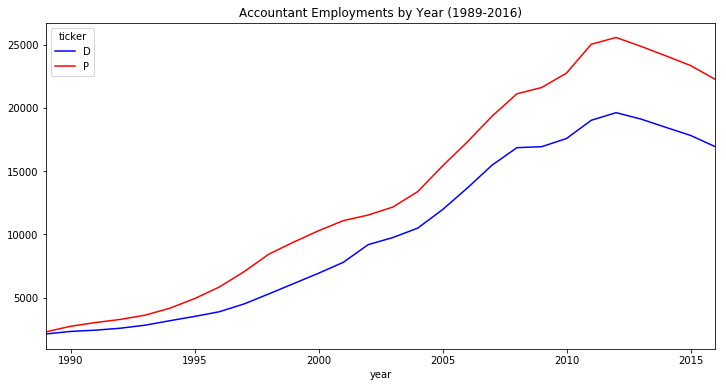

In [12]:
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),color=color_styles_2,title="Accountant Employments by Year (1989-2016)"
)
plt.show()

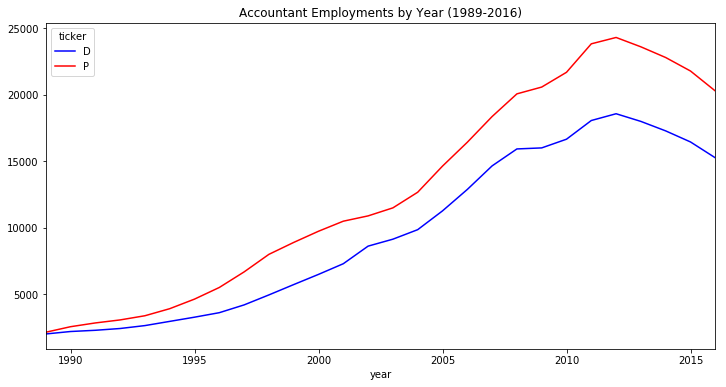

In [13]:
count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
empl_by_years = count_by_years.groupby(['ticker','type']).apply(
    lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
).reset_index(drop=True).pivot_table(
    index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
).assign(
    employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
).drop('cumsum',axis=1).reset_index()
empl_by_years.columns = empl_by_years.columns.droplevel('type')
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),color=color_styles_2,title="Accountant Employments by Year (1989-2016)"
)
plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

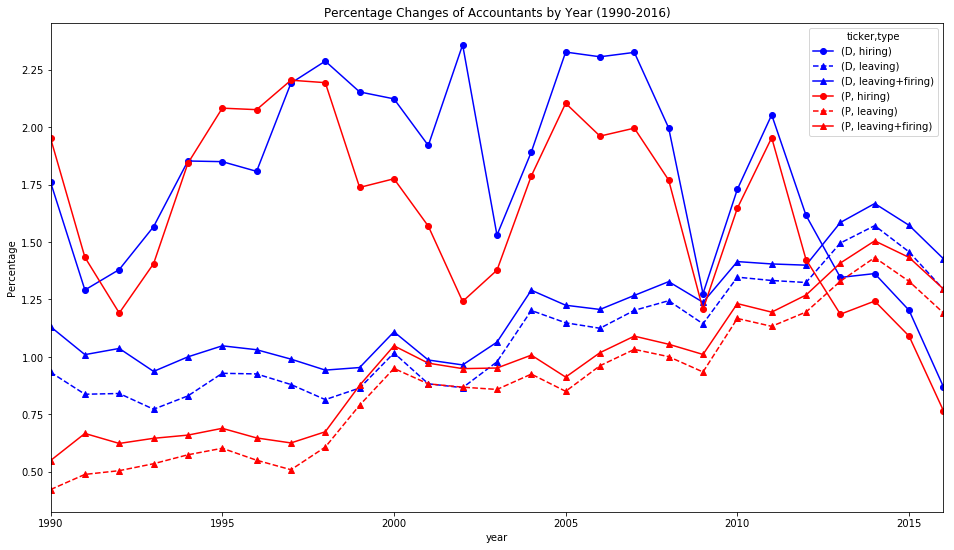

In [14]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# Plot by year.
prop_by_months.pivot_table(
    index = ['ticker','year'], columns = 'type', values = 'prop'
).reset_index().assign(
    **{"leaving+firing":lambda df:(df.leaving+df.firing)}
).pivot_table(
    index='year', columns='ticker', values=['hiring','leaving','leaving+firing']
).reorder_levels(
    ['ticker','type'],axis=1
).sort_index(axis=1).plot(
    style=line_styles, figsize=(16,9), title="Percentage Changes of Accountants by Year (1990-2016)"
).set_ylabel('Percentage')
plt.show()

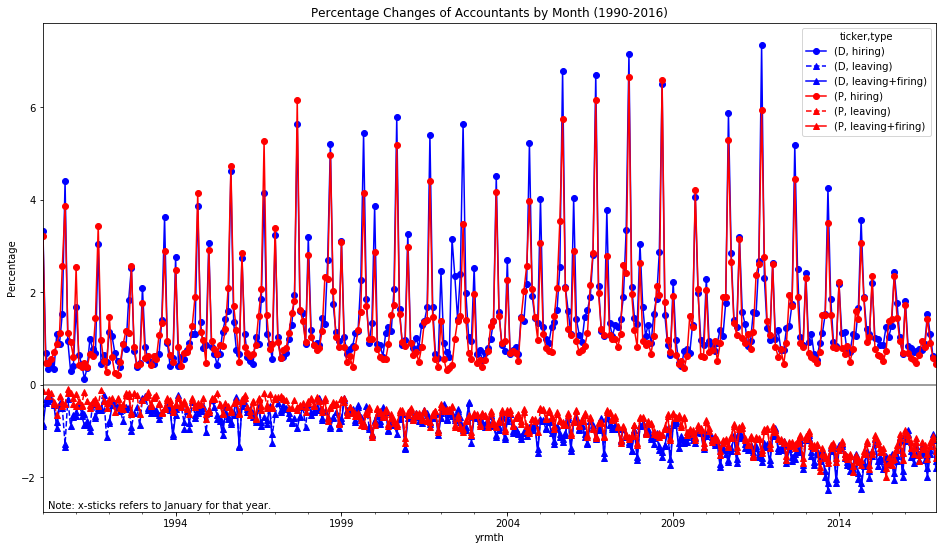

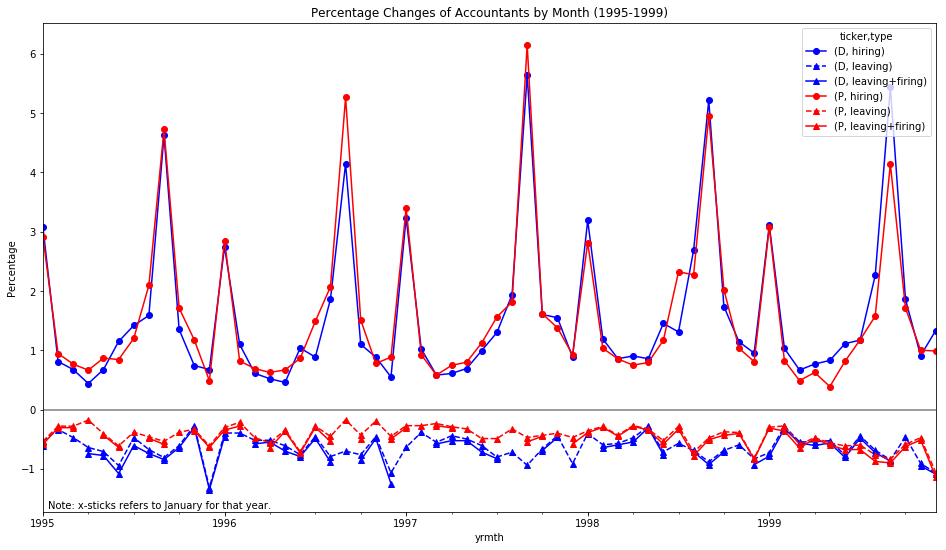

In [15]:
# Plot by month.
## Define a routine for plotting over segments.
def plot_by_month(start_year=1990,end_year=2016):
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop'
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).pivot_table(
        index='yrmth', columns='ticker', values=['hiring','leaving','leaving+firing']
    ).reorder_levels(
        ['ticker','type'],axis=1
    ).sort_index(axis=1).plot(
        style=line_styles, figsize=(16,9), 
        title="Percentage Changes of Accountants by Month ({}-{})".format(start_year,end_year)
    ).set_ylabel('Percentage')
    plt.hlines(0,pd.Period('{}-01'.format(start_year)),pd.Period('{}-12'.format(end_year)),colors='tab:gray')
    plt.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
    plt.show()

    
plot_by_month() # Plot by month over the whole timespan.
plot_by_month(1995,1999) # An example for plotting by month over 1995-1999.

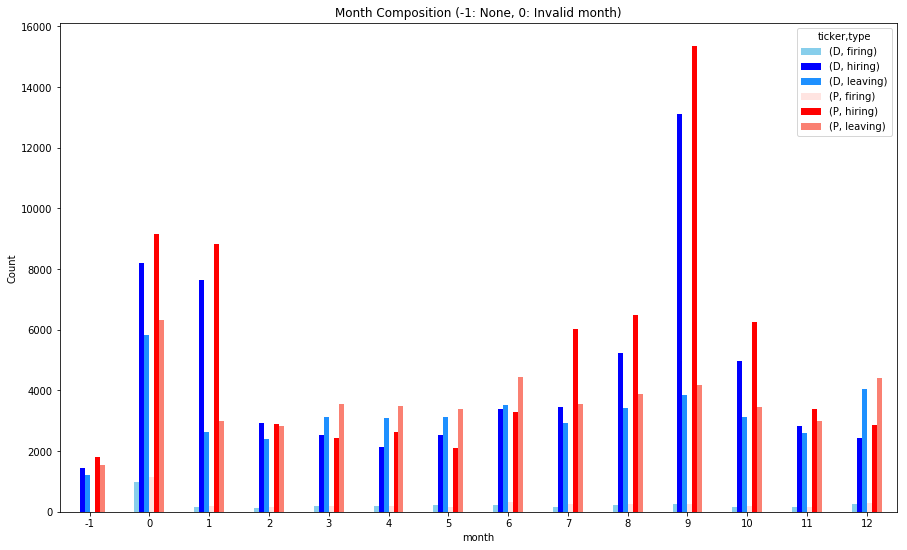

In [16]:
# Month composition.
empl_changes_df.assign(count=1).pivot_table(
    index = 'month', columns = ['ticker','type'], values='count', aggfunc='sum', fill_value=0
).plot.bar(
    figsize=(15,9),color=color_styles,rot=0,
    title="Month Composition (-1: None, 0: Invalid month)"
).set_ylabel("Count")
plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

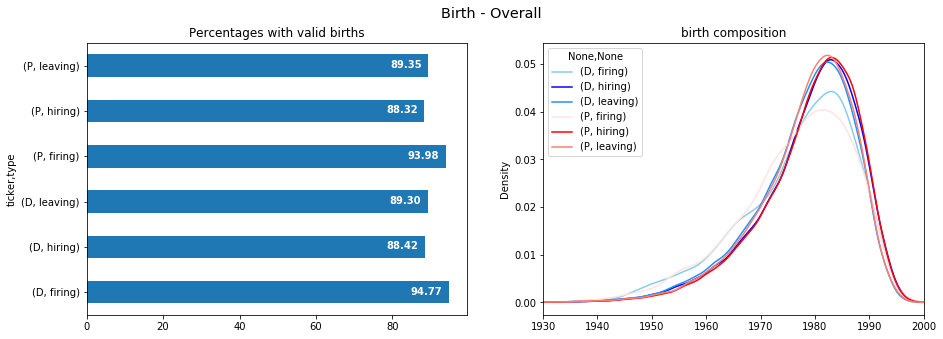

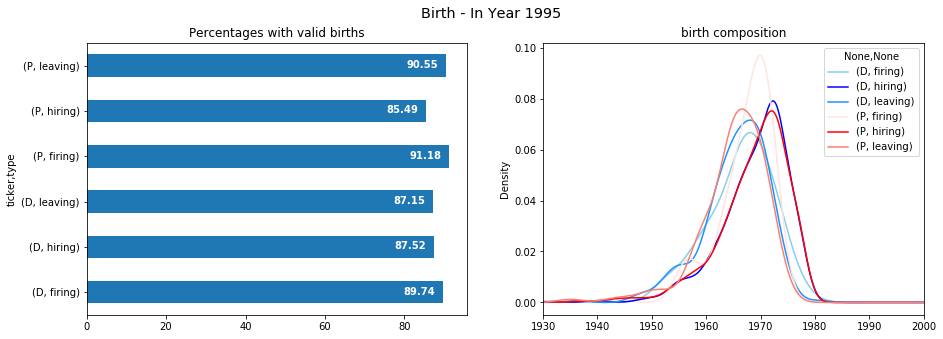

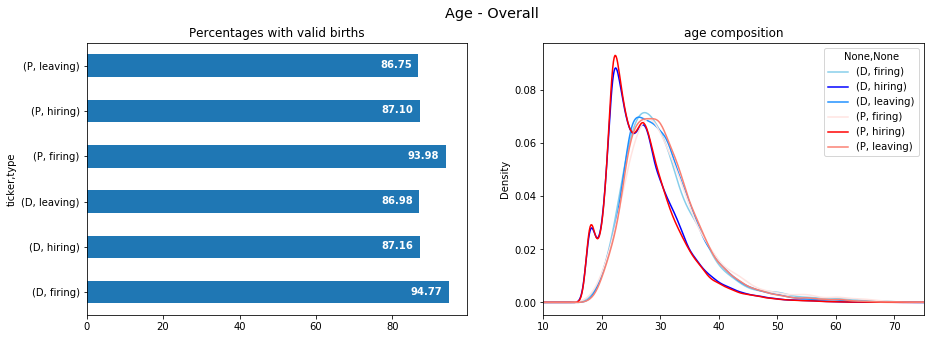

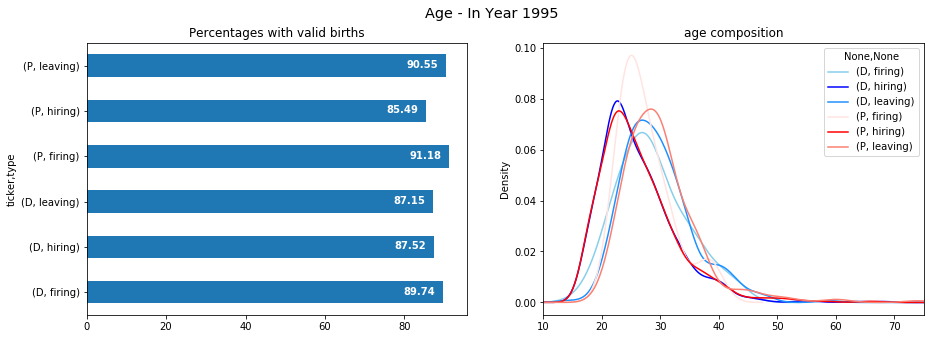

In [17]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
def birth_plot(DF,var,title,xlim=None):
    plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(title,fontsize="x-large")
    plt.subplot(121)
    to_plot = DF.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(DF.loc[~DF[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
    
birth_plot(birth_df,'birth',"Birth - Overall",(1930,2000))
birth_plot(birth_df.loc[birth_df.year==1995],'birth',"Birth - In Year 1995",(1930,2000))
birth_plot(birth_df,'age',"Age - Overall",(10,75))
birth_plot(birth_df.loc[birth_df.year==1995],'age',"Age - In Year 1995",(10,75))

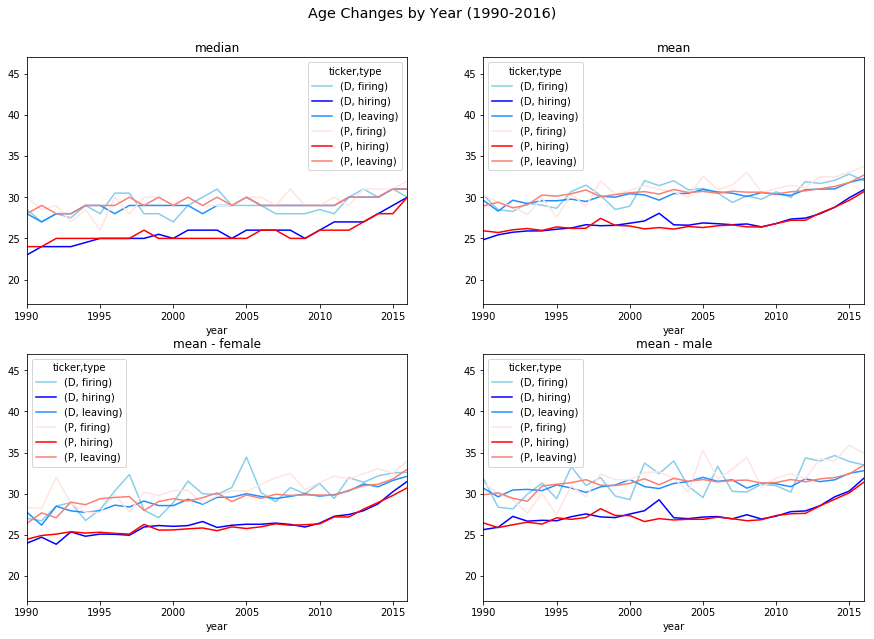

In [18]:
# Age changes by year.
fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Age Changes by Year (1990-2016)',fontsize='x-large',y=0.95)
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='median'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
birth_df.loc[empl_changes_df.gender=='1'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
birth_df.loc[empl_changes_df.gender=='2'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
plt.show()

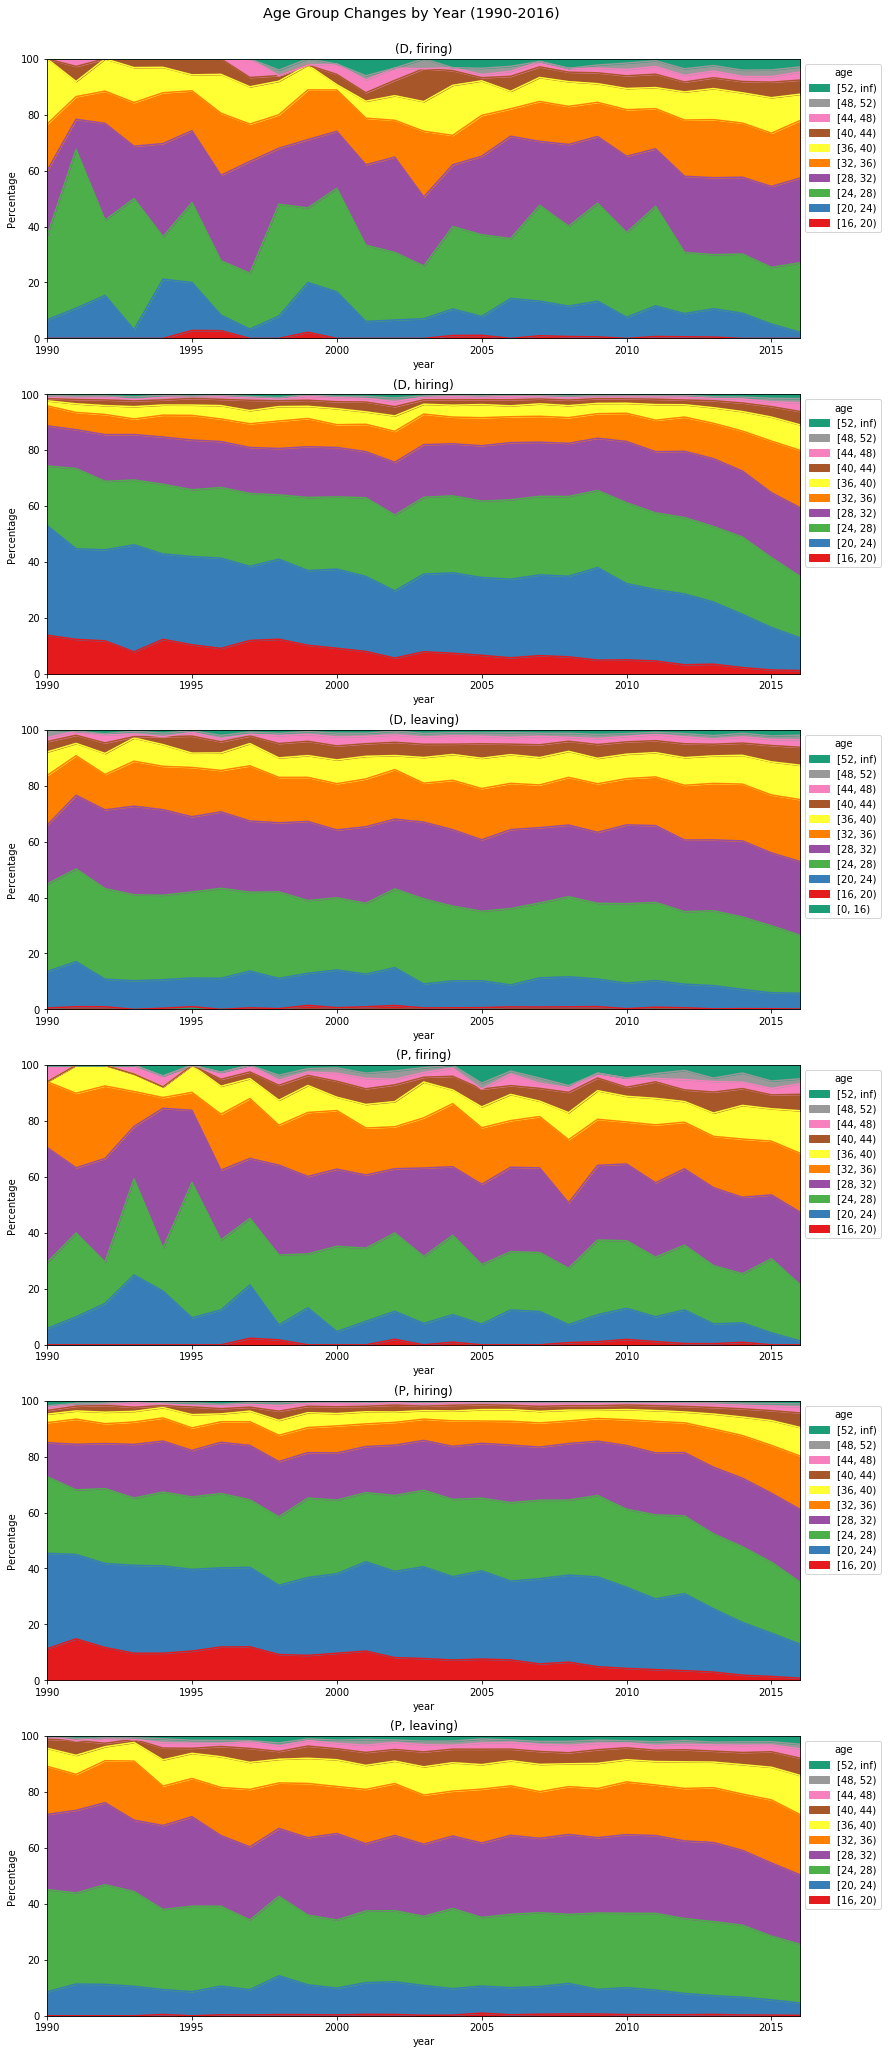

In [19]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

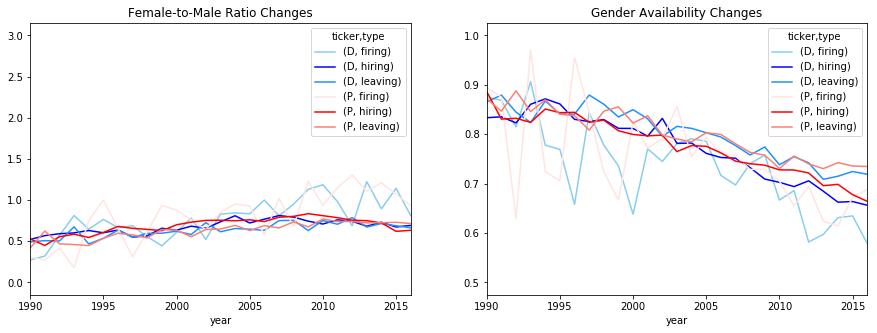

In [20]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
).plot(xlim=(1990,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1)
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x!='0').sum()/x.size)
).plot(xlim=(1990,2016),color=color_styles,title="Gender Availability Changes",ax=ax2)
plt.show()

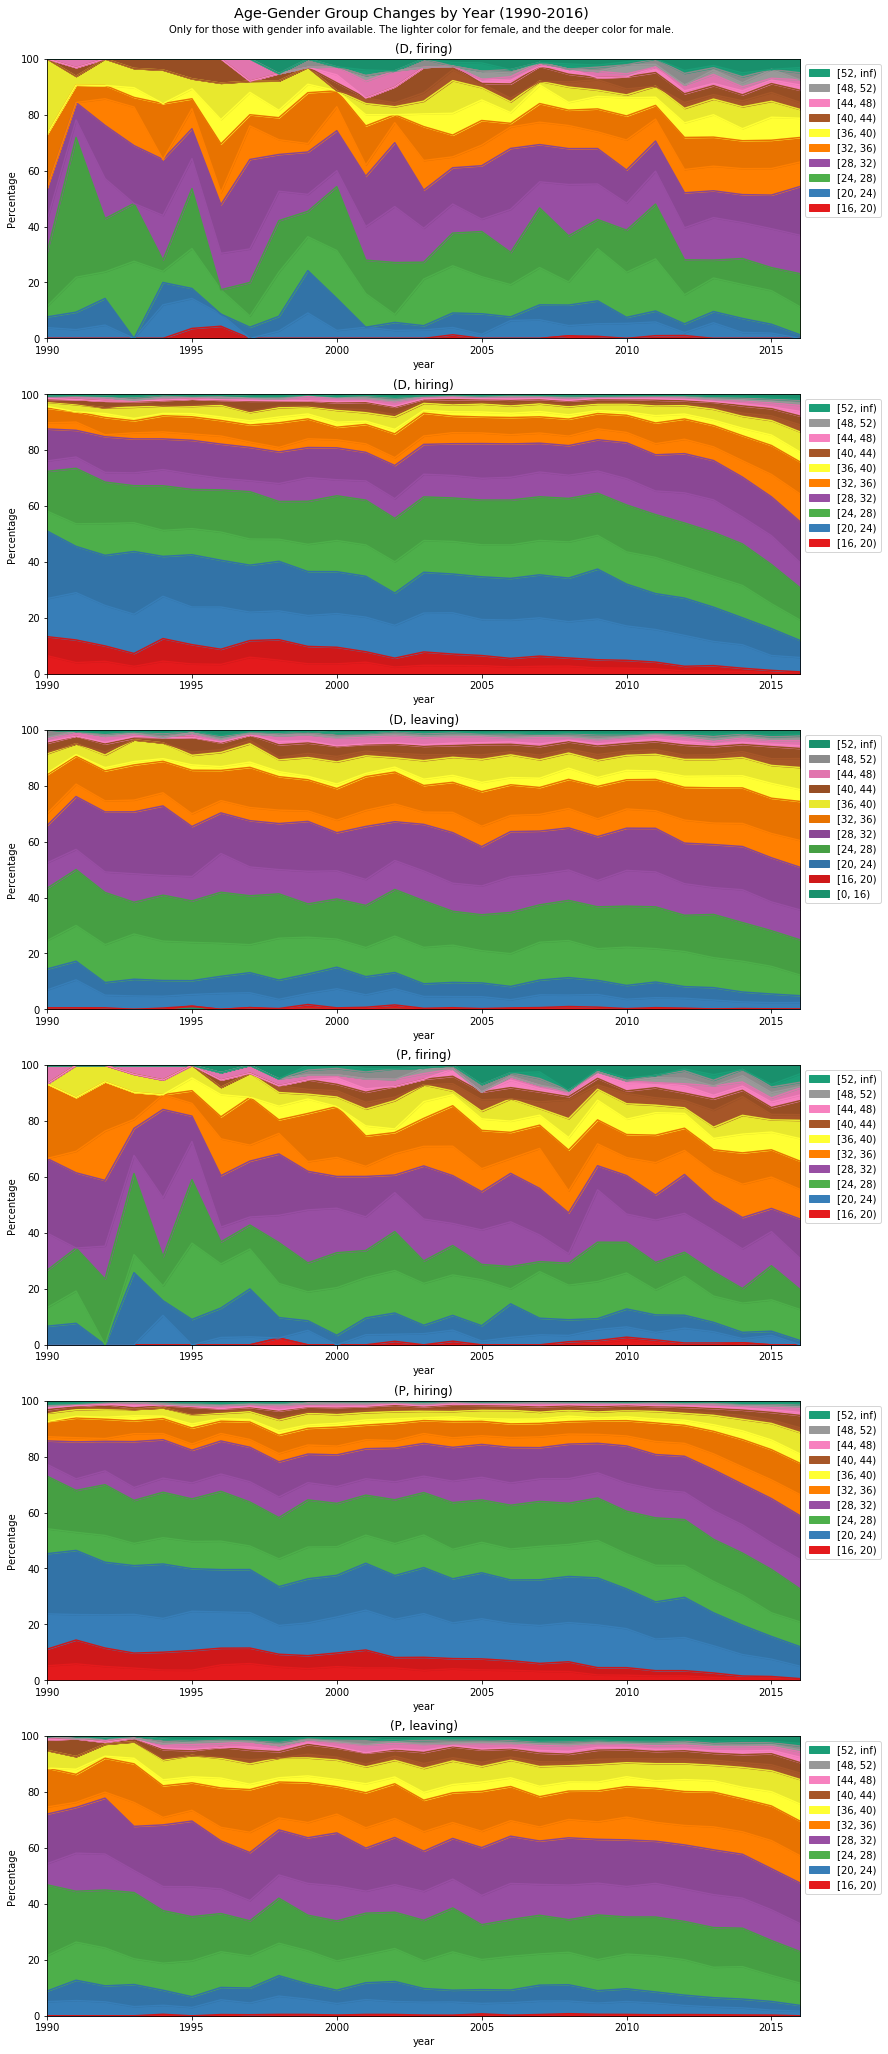

In [21]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.90)
fig.text(0.25,0.89,
         "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Secondary Skill.

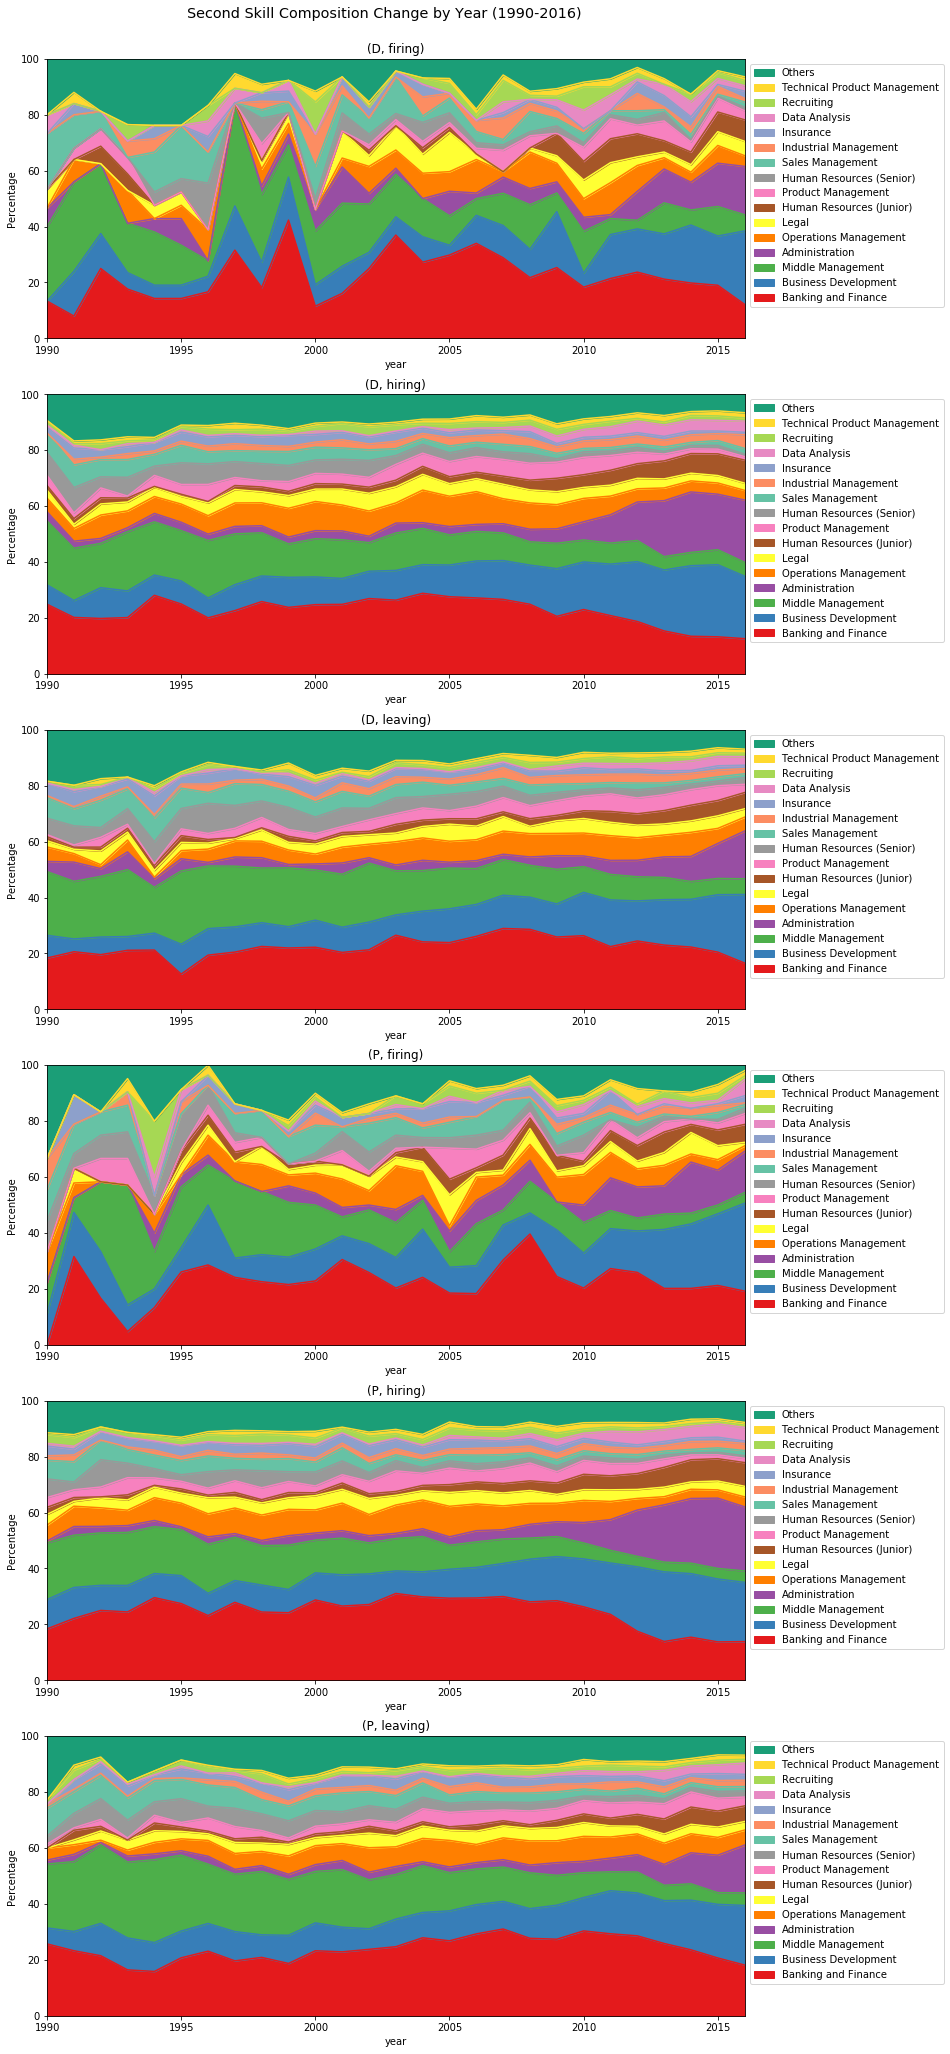

In [22]:
skill2_to_plot = empl_changes_df.loc[lambda df:df.skill2!='']

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill2_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [23]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

job_role  count  prop       depmt   prop                    edu  \
0   Senior Associate   1621  5.97  Accounting  62.50              Bachelors   
1            Manager   1328  4.89   Oversight  18.64      Masters excl. MBA   
2            Auditor   1067  3.93          Hr  11.68           None/Unknown   
3     Senior Manager    985  3.63    Business   4.28                    MBA   
4     Senior Auditor    927  3.42  Operations   0.96  Doctorate (PhD/JD/MD)   
5          Associate    887  3.27   Marketing   0.86            High school   
6  Assistant Manager    762  2.81  Technology   0.67      Vocational degree   
7       Audit Senior    684  2.52       Legal   0.35             Associates   
8      Audit Manager    684  2.52  Management   0.04                    NaN   
9            Partner    681  2.51  Production   0.02                    NaN   

    prop  
0  46.76  
1  23.50  
2  15.30  
3  10.42  
4   2.62  
5   1.02  
6   0.29  
7   0.10  
8    NaN  
9    NaN

job_role                 depmt  \
110064                                    Associate                         
203262  Consultant Performance Improvement Services                    HR   
193540                             Senior Associate                         
152468                             Junior Associate                         
167273                                      Manager                         
196199                      IT Auditor & Consultant            TECHNOLOGY   
30946                             Senior Consultant                         
54450                           Senior Professional                         
176413                      Audit senior consultant            ACCOUNTING   
110633                                     Director             OVERSIGHT   
119804                   Manager Financial Services         HR,ACCOUNTING   
143270                                Audit Manager            ACCOUNTING   
218524                                      Manager                         
169627                            Senior Accountant                         
37719         Advisory Senior Associate - Forensics                         
238305                                 Audit Senior            ACCOUNTING   
154425                                   Tax Lawyer            ACCOUNTING   
4729                                Audit Associate            ACCOUNTING   
86697                              External Auditor                         
201762                                      Partner             OVERSIGHT   
127239                             Senior Associate                         
54749                                 Audit Partner  ACCOUNTING,OVERSIGHT   
162574         Senior Associate Audit and Assurance            ACCOUNTING   
35160                              Senior Associate                         
231437                                  Consultoría                         
98933                              Senior Associate                         
217835                               Senior Manager                         
229213                            Assistant Manager                         
80929               Financial Institutions Advisory            ACCOUNTING   
60707                                Senior Manager                         

                          edu f_elite  
110064              Bachelors   False  
203262              Bachelors   False  
193540           None/Unknown   False  
152468              Bachelors   False  
167273              Bachelors   False  
196199              Bachelors   False  
30946               Bachelors   False  
54450                     MBA   False  
176413              Bachelors   False  
110633      Masters excl. MBA   False  
119804              Bachelors   False  
143270              Bachelors   False  
218524              Bachelors   False  
169627                    MBA    True  
37719               Bachelors   False  
238305      Masters excl. MBA   False  
154425      Masters excl. MBA   False  
4729        Masters excl. MBA    True  
86697       Masters excl. MBA   False  
201762  Doctorate (PhD/JD/MD)   False  
127239                    MBA   False  
54749            None/Unknown   False  
162574              Bachelors   False  
35160       Vocational degree   False  
231437              Bachelors   False  
98933            None/Unknown   False  
217835  Doctorate (PhD/JD/MD)    True  
229213              Bachelors   False  
80929   Doctorate (PhD/JD/MD)   False  
60707            None/Unknown   False

job_role  count  prop       depmt   prop                    edu  \
0              Auditor    827  4.68  Accounting  79.55              Bachelors   
1       Senior Auditor    771  4.36          Hr   7.04      Masters excl. MBA   
2     Senior Associate    646  3.65   Oversight   5.31           None/Unknown   
3            Associate    627  3.55    Business   3.78                    MBA   
4         Audit Senior    379  2.14  Technology   1.32            High school   
5       Tax Consultant    331  1.87  Operations   1.19  Doctorate (PhD/JD/MD)   
6              Manager    326  1.84   Marketing   1.14      Vocational degree   
7  Assurance Associate    324  1.83       Legal   0.58             Associates   
8      Audit Assistant    317  1.79  Management   0.06                    NaN   
9      Audit Associate    316  1.79  Production   0.04                    NaN   

    prop  
0  43.59  
1  28.77  
2  13.82  
3   9.63  
4   1.87  
5   1.51  
6   0.68  
7   0.14  
8    NaN  
9    NaN

job_role          depmt  \
5332                                  Senior Associate                  
166435                                  Tax Consultant     ACCOUNTING   
62642                                          Manager                  
35818             Senior Associate - Forensic Services             HR   
169904          Assistant Manager (last held position)                  
69767                              Assurance Associate                  
93555                                   Senior Auditor                  
75239                       Senior Assurance Associate                  
229200                                       Assistant                  
225260                                          Senior                  
158965                                       Associate                  
45726                                Senior Accountant                  
76828                            Senior Tax Consultant     ACCOUNTING   
102768                               senior consultant                  
146112                               Assistant Manager                  
35245                                Associate Auditor                  
82579          Research & Development (R&D) Consultant     TECHNOLOGY   
27535                                     Audit Senior     ACCOUNTING   
118158                                         Manager                  
43292                       Supervising Senior Auditor                  
65260                                          Auditor                  
184646     Project Manager - Business process services             HR   
134003                            Auditor Supervisor I                  
223767                                 Audit Associate     ACCOUNTING   
221931                                 Working Student                  
35800                                   Tax Consultant     ACCOUNTING   
169330                                 Audit Associate     ACCOUNTING   
152410       Financial Auditor (Industries & Services)  HR,ACCOUNTING   
215390  Consultant CFO Service hos Deloitte Consulting      MARKETING   
201294                                         Auditor                  

                      edu f_elite  
5332         None/Unknown   False  
166435  Masters excl. MBA   False  
62642                 MBA   False  
35818                 MBA   False  
169904          Bachelors   False  
69767           Bachelors   False  
93555        None/Unknown   False  
75239           Bachelors   False  
229200          Bachelors   False  
225260          Bachelors   False  
158965          Bachelors   False  
45726                 MBA   False  
76828   Masters excl. MBA   False  
102768          Bachelors   False  
146112          Bachelors   False  
35245           Bachelors   False  
82579   Masters excl. MBA   False  
27535           Bachelors   False  
118158  Masters excl. MBA   False  
43292        None/Unknown   False  
65260        None/Unknown   False  
184646  Masters excl. MBA   False  
134003  Masters excl. MBA   False  
223767  Masters excl. MBA   False  
221931  Masters excl. MBA   False  
35800           Bachelors   False  
169330          Bachelors   False  
152410  Masters excl. MBA   False  
215390          Bachelors   False  
201294          Bachelors   False

job_role  count  prop       depmt   prop                    edu  \
0            Auditor    651  5.54  Accounting  72.65              Bachelors   
1     Senior Auditor    598  5.09   Oversight  10.82      Masters excl. MBA   
2            Manager    548  4.66          Hr   8.28                    MBA   
3   Senior Associate    479  4.07    Business   3.77           None/Unknown   
4       Audit Senior    404  3.44  Technology   1.42  Doctorate (PhD/JD/MD)   
5      Audit Manager    387  3.29  Operations   1.32            High school   
6     Senior Manager    349  2.97   Marketing   1.06      Vocational degree   
7  Senior Consultant    325  2.76       Legal   0.49             Associates   
8  Assistant Manager    287  2.44  Production   0.13                    NaN   
9         Consultant    236  2.01  Management   0.06                    NaN   

    prop  
0  47.40  
1  18.06  
2  15.83  
3  14.70  
4   2.19  
5   1.18  
6   0.46  
7   0.18  
8    NaN  
9    NaN

job_role          depmt  \
224017                                      Audit Manager     ACCOUNTING   
99639                                    Senior Associate                  
230130                                          Associate                  
172466                                            Revisor                  
103738                Manager - Tax Management Consulting     ACCOUNTING   
161244                                     ERS Consultant                  
18879                                        Audit Senior     ACCOUNTING   
80027                                      Senior Analyst                  
18231                                       Article clerk                  
34448   Senior Manager Internal Audit Government & Pub...     ACCOUNTING   
193494                              Tax Senior Consultant     ACCOUNTING   
211216                                     Senior Auditor                  
64888                                      Senior Manager                  
107122                                    Account Analyst                  
193495                              Tax Senior Consultant     ACCOUNTING   
220015                                   Tax Professional     ACCOUNTING   
180363  Senior Associate Forensics / Experienced Assoc...                  
135332                                            Analyst                  
29984                               Senior Manager- Audit     ACCOUNTING   
201160                                      Audit Manager     ACCOUNTING   
127768                              Senior Tax Consultant     ACCOUNTING   
191689                                            Auditor                  
116969                                  Senior Accountant                  
63073              Associate Audit and Assurance Services  HR,ACCOUNTING   
9560                                              Manager                  
65691                                 Assurance Associate                  
222065   Auditor Computer Auditor & Management Consultant                  
187020            Assistant Manager - Audit and Assurance     ACCOUNTING   
56136                                           Associate                  
65435                                      Tax Consultant     ACCOUNTING   

                          edu f_elite  
224017              Bachelors   False  
99639                     MBA    True  
230130                    MBA    True  
172466           None/Unknown   False  
103738           None/Unknown   False  
161244           None/Unknown   False  
18879   Doctorate (PhD/JD/MD)   False  
80027   Doctorate (PhD/JD/MD)   False  
18231               Bachelors   False  
34448               Bachelors   False  
193494              Bachelors   False  
211216      Masters excl. MBA   False  
64888            None/Unknown   False  
107122      Masters excl. MBA   False  
193495              Bachelors   False  
220015              Bachelors   False  
180363              Bachelors   False  
135332                    MBA   False  
29984               Bachelors   False  
201160           None/Unknown   False  
127768           None/Unknown   False  
191689      Masters excl. MBA   False  
116969              Bachelors   False  
63073       Masters excl. MBA   False  
9560                      MBA   False  
65691                     MBA    True  
222065           None/Unknown   False  
187020            High school   False  
56136       Masters excl. MBA   False  
65435                     MBA   False

job_role  count  prop       depmt   prop                    edu  \
0     Senior Associate    534  5.23  Accounting  79.18              Bachelors   
1            Associate    501  4.91          Hr   7.21      Masters excl. MBA   
2  Assurance Associate    467  4.58   Oversight   6.37           None/Unknown   
3         Audit Senior    389  3.81    Business   2.73                    MBA   
4      Audit Associate    312  3.06  Operations   1.35            High school   
5              Auditor    280  2.74   Marketing   1.32  Doctorate (PhD/JD/MD)   
6      Audit Assistant    229  2.24  Technology   1.25      Vocational degree   
7        Tax Associate    223  2.19       Legal   0.48             Associates   
8       Tax Consultant    212  2.08  Production   0.07                    NaN   
9    Assistant Manager    206  2.02  Management   0.05                    NaN   

    prop  
0  56.51  
1  24.18  
2  10.45  
3   5.23  
4   1.67  
5   1.20  
6   0.46  
7   0.30  
8    NaN  
9    NaN

job_role          depmt  \
159642                       Senior Associate (Assurance)                  
107293                                   Senior Associate                  
130597          Experienced Associate - Captive Insurance     ACCOUNTING   
107629                           Client Service Executive      MARKETING   
21701                                    Senior Associate                  
140337                                       Audit Senior     ACCOUNTING   
121327                       Team Case Competition Member                  
235915                                  Assistant Manager                  
84874                                    Senior Associate                  
208701                                   senior associate                  
97481   Senior Advisory Associate Finance Transformati...  HR,ACCOUNTING   
133864                                Assurance Associate                  
56242                                     Audit Assistant     ACCOUNTING   
117055                             Audit Senior Assistant     ACCOUNTING   
80167                                         Tax Analyst     ACCOUNTING   
134426                                     Tax Consultant     ACCOUNTING   
1216                                            Associate                  
48079                                    SENIOR ASSOCIATE                  
10436                                   Assistant Manager                  
147223                                   Senior Associate                  
209404                                      Audit Pratice     ACCOUNTING   
223028                                     Tax Consultant     ACCOUNTING   
72037                                     Audit Associate     ACCOUNTING   
28327                         Business Technology Analyst     TECHNOLOGY   
32447             Assurance Associate - Real Estate (CPA)     OPERATIONS   
3790                          Audit Experienced Associate     ACCOUNTING   
190750                                          Associate                  
230435                                            Auditor                  
163869                                       Audit Senior     ACCOUNTING   
184993                                          Executive                  

                          edu f_elite  
159642              Bachelors   False  
107293              Bachelors   False  
130597      Masters excl. MBA   False  
107629            High school   False  
21701               Bachelors   False  
140337              Bachelors   False  
121327              Bachelors   False  
235915      Masters excl. MBA   False  
84874               Bachelors   False  
208701                    MBA   False  
97481               Bachelors   False  
133864              Bachelors   False  
56242       Masters excl. MBA   False  
117055      Masters excl. MBA   False  
80167       Masters excl. MBA   False  
134426                    MBA   False  
1216                Bachelors   False  
48079               Bachelors   False  
10436       Masters excl. MBA   False  
147223              Bachelors   False  
209404                    MBA   False  
223028      Masters excl. MBA   False  
72037       Masters excl. MBA   False  
28327       Masters excl. MBA   False  
32447       Masters excl. MBA   False  
3790        Masters excl. MBA   False  
190750              Bachelors   False  
230435  Doctorate (PhD/JD/MD)   False  
163869              Bachelors   False  
184993             Associates   False

job_role  count  prop       depmt   prop                    edu  \
0            Manager    587  7.09   Oversight  38.49              Bachelors   
1  Senior Consultant    464  5.61  Accounting  33.45           None/Unknown   
2     Senior Manager    438  5.29  Technology  10.88      Masters excl. MBA   
3         Consultant    388  4.69          Hr   9.68                    MBA   
4   Senior Associate    227  2.74    Business   4.09  Doctorate (PhD/JD/MD)   
5  Assistant Manager    211  2.55  Operations   1.97            High school   
6            Partner    204  2.46   Marketing   1.10      Vocational degree   
7           Director    203  2.45       Legal   0.33             Associates   
8            Auditor    184  2.22  Management   0.02                    NaN   
9     Senior Auditor    144  1.74         NaN    NaN                    NaN   

    prop  
0  45.30  
1  21.09  
2  20.14  
3   9.78  
4   1.91  
5   1.09  
6   0.65  
7   0.05  
8    NaN  
9    NaN

job_role  \
11929                                          Consultant   
171723              Auditor (Trade Industries & Services)   
162800                                      Audit Manager   
1068                                       Senoir Manager   
143116  Manager Risk Management and Internal Controls ...   
215352                                          Associate   
90274                                   Assistant Manager   
148821  Senior Consultant IT & Business Process Assurance   
7094      Senior Associate Contract Set-up to Collections   
65419                                   Assistant Manager   
7571                                             Director   
90325                                          Consultant   
83625                                       Audit Manager   
106834                       Manager Security and Privacy   
152451                                Federal Tax Manager   
7921                                       Sr. Consultant   
55165                                      Senior Manager   
102538                            Audit and Risk Services   
216608                                            Manager   
143117  Manager Risk Management and Internal Controls ...   
24310            Advisor in Systems and Process Assurance   
174422                                            Auditor   
211731                                            Manager   
144081                       Senior Management Consultant   
32647                              Manager Risk Assurance   
64708                                   Prüfungsassistent   
239048                                     Senior Analyst   
219349                                       Audit senior   
224312                Wirtschaftsprüfer Manager Prokurist   
35638                                   Assistant Manager   

                          depmt                edu f_elite  
11929                                          MBA   False  
171723                       HR       None/Unknown   False  
162800               ACCOUNTING                MBA   False  
1068                                  None/Unknown   False  
143116                OVERSIGHT          Bachelors   False  
215352                                   Bachelors   False  
90274                            Masters excl. MBA   False  
148821               TECHNOLOGY       None/Unknown   False  
7094           ACCOUNTING,LEGAL  Masters excl. MBA   False  
65419                                    Bachelors   False  
7571                  OVERSIGHT       None/Unknown   False  
90325                                    Bachelors   False  
83625                ACCOUNTING  Masters excl. MBA   False  
106834               OPERATIONS          Bachelors   False  
152451               ACCOUNTING                MBA   False  
7921                                     Bachelors   False  
55165                            Masters excl. MBA   False  
102538  HR,ACCOUNTING,OVERSIGHT       None/Unknown   False  
216608                           Masters excl. MBA   False  
143117                OVERSIGHT          Bachelors   False  
24310                TECHNOLOGY  Masters excl. MBA   False  
174422                           Masters excl. MBA   False  
211731                                None/Unknown   False  
144081                                   Bachelors   False  
32647                 OVERSIGHT          Bachelors   False  
64708                                 None/Unknown   False  
239048                                   Bachelors   False  
219349               ACCOUNTING  Masters excl. MBA   False  
224312                                None/Unknown   False  
35638                                 None/Unknown   False

## By Country.

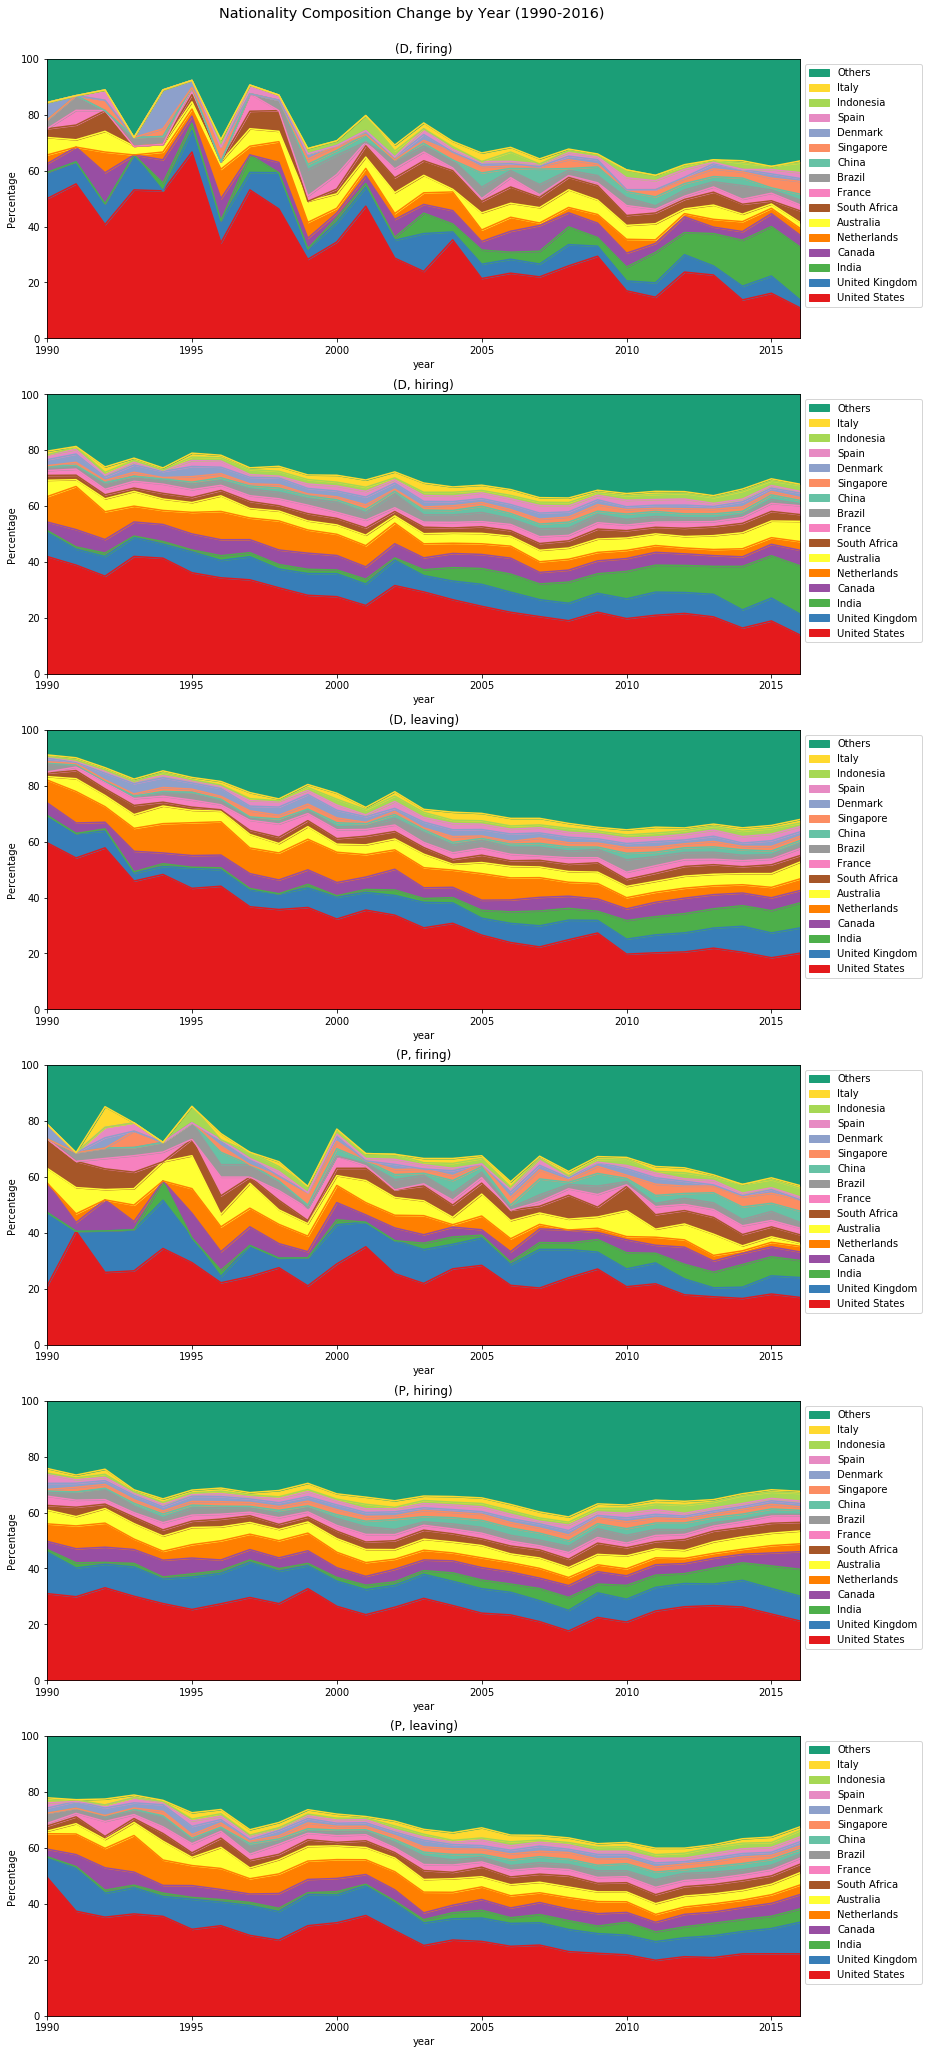

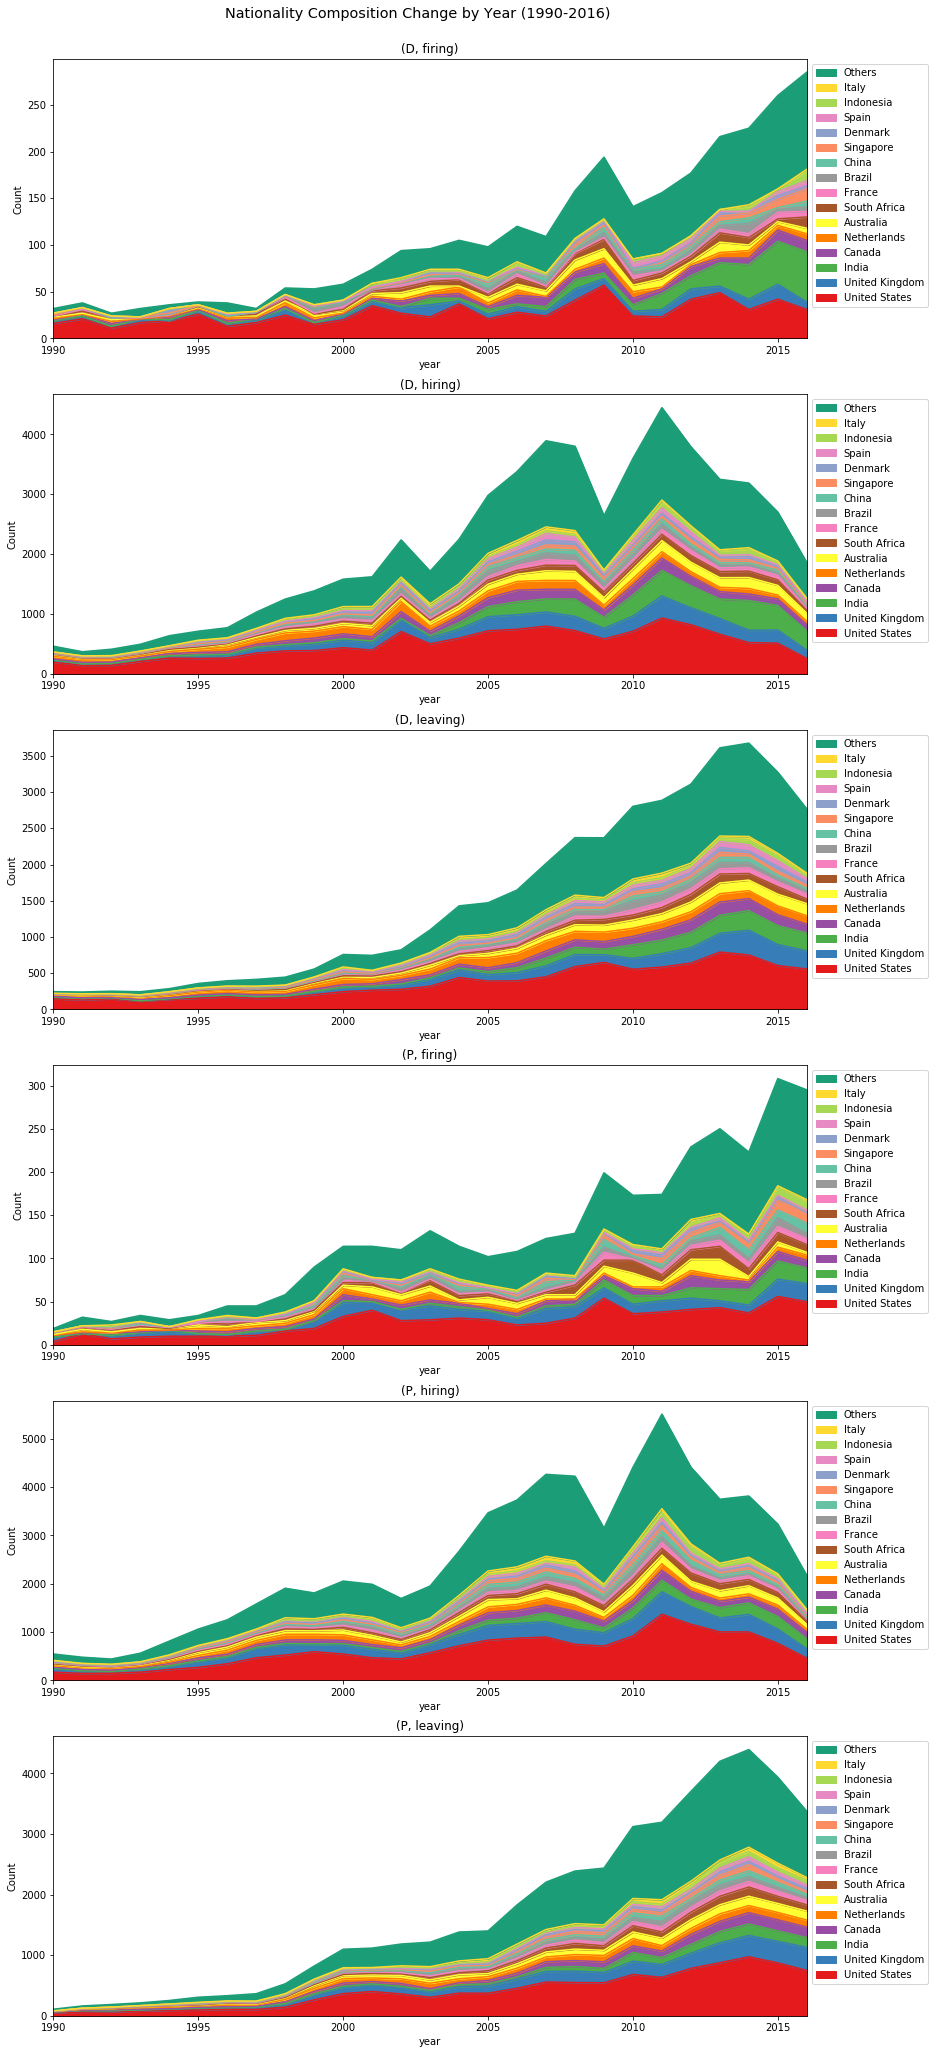

In [24]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    )
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        title=str(idx).replace("'","")
    )
    ax.set_ylabel("Count")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

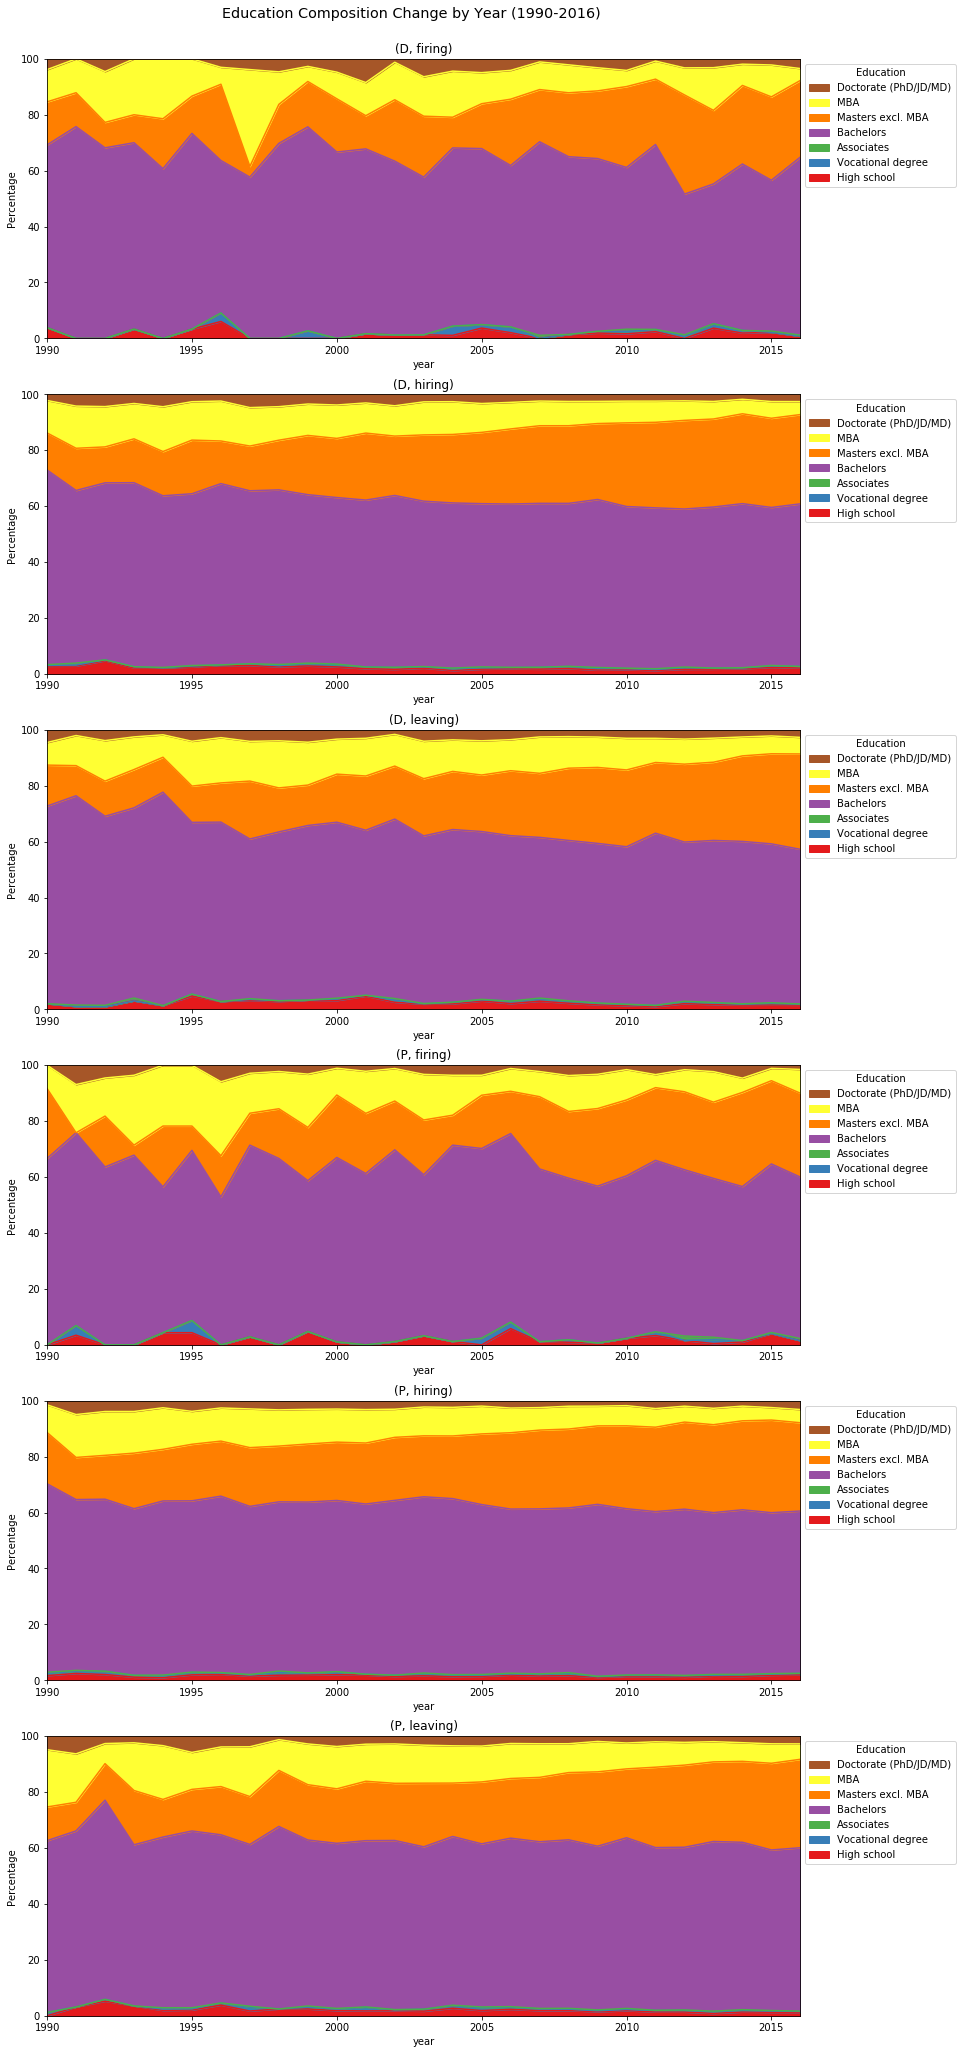

In [25]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



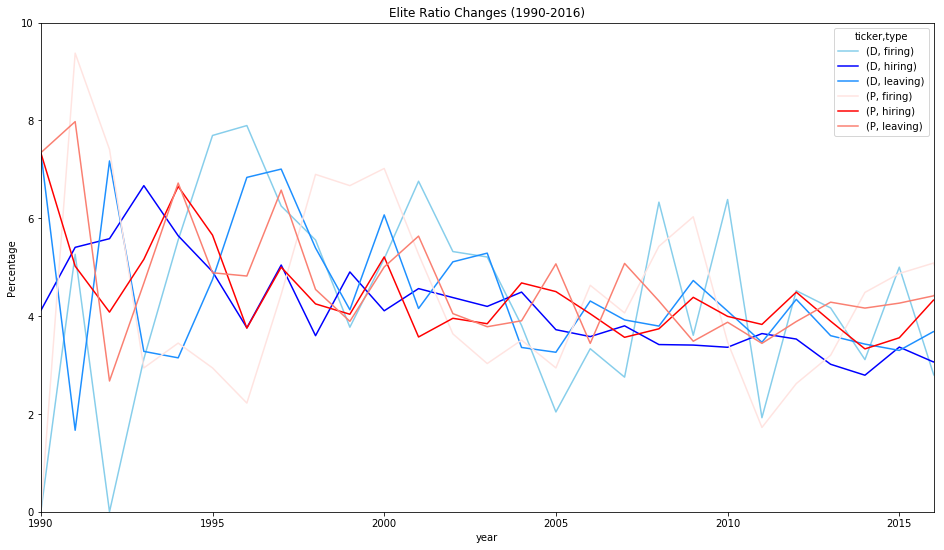

In [26]:
ax = empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='f_elite',
    aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
).plot(
    xlim=(1990,2016),ylim=(0,10),color=color_styles,
    title="Elite Ratio Changes (1990-2016)",figsize=(16,9)
)
ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [27]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

Industry group                  NAICS2
0           Natural Resources and Mining                  11, 21
1                           Construction                      23
2                          Manufacturing              31, 32, 33
3   Trade, Transportation, and Utilities  42, 44, 45, 48, 49, 22
4                            Information                      51
5                   Financial Activities                  52, 53
6     Professional and Business Services              54, 55, 56
7          Education and Health Services                  61, 62
8                Leisure and Hospitality                  71, 72
9                         Other Services                      81
10                 Public Administration                      92
11                  Unknown/Unclassified            99, , MI, 46

Note: `46` seems to be a wrong NAICS2 code.

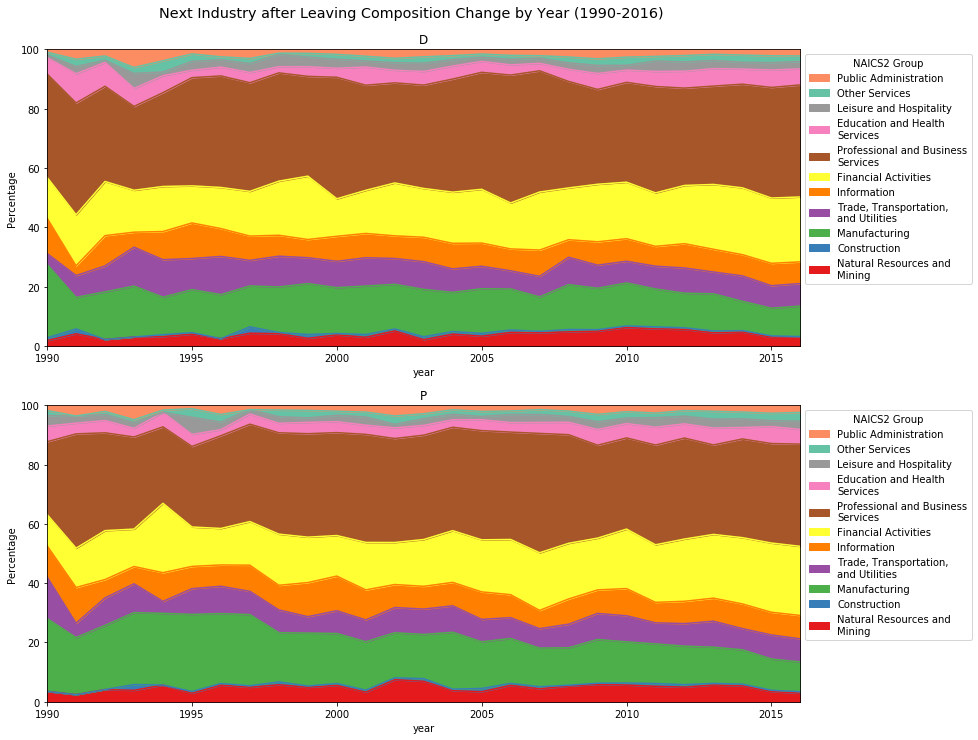

In [28]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(2,1,figsize=(13.5,12))
fig.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.93)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

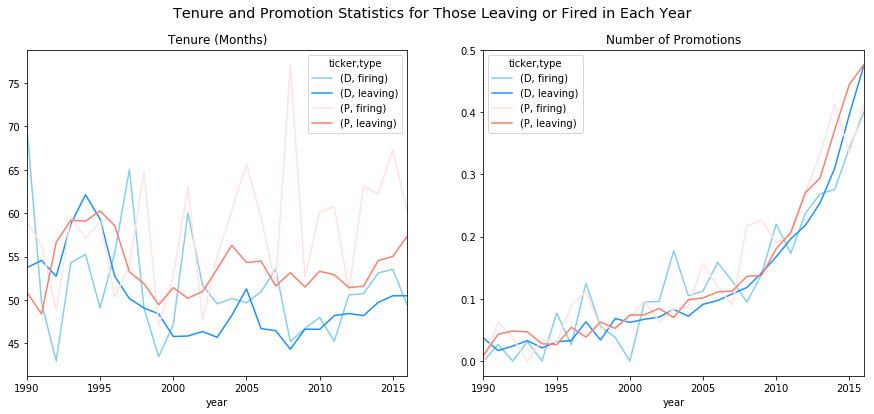

In [29]:
# Calculate.
to_plot = empl_changes_df.loc[lambda df:(df.type!='hiring')&(df.year>=1990)&(df.year<=2016)].astype(
    {'tenure':'Int64','nprom':'Int64'}
).pivot_table(
    columns=['ticker','type'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
)

# Plot.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
to_plot['tenure'].plot(
    title="Tenure (Months)", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax1
)
to_plot['nprom'].plot(
    title="Number of Promotions", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax2
)
plt.show()

## By Hierarchies for Top 1,000 Jobs.

In [30]:
# Read data.
job_titles_df = pd.read_excel(r"../job_titles/job_titles_checked.xlsx", sheet_name="Accounting & Auditing")
job_titles_df = job_titles_df.loc[lambda df:df.senior0>0]
assert job_titles_df.job_title.is_unique
empl_job_titles_df = empl_changes_df.loc[lambda df:df.year>=1990].assign(
    job_title = lambda df:df.job_role.apply(lambda x:x.split(",")[0])
)[["type", "ticker", "year", "job_title"]]
empl_job_titles_df = empl_job_titles_df.merge(job_titles_df, on="job_title", how="left", indicator="mark")

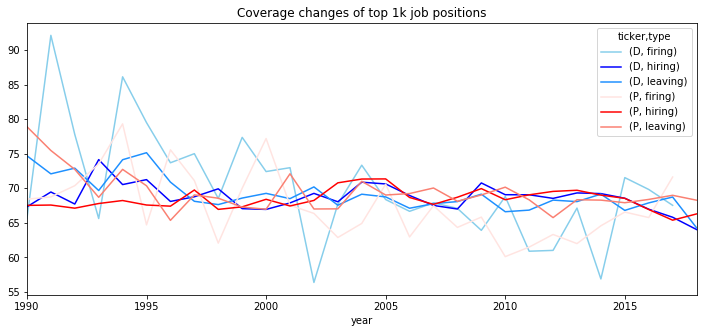

In [31]:
# Plot availability.
empl_job_titles_df.groupby(["year", "ticker", "type"])["mark"].apply(
    lambda ser:(ser=="both").sum()/len(ser)*100
).rename("prop").reset_index().pivot_table(index="year", columns=["ticker","type"], values="prop").plot(
    figsize=(12,5), title="Coverage changes of top 1k job positions",color=color_styles
)
plt.show()

In [32]:
empl_top1k_jobs_df = empl_job_titles_df.loc[lambda df:df.mark=="both"]
senior_lst = {1:"Junior", 2:"Senior", 3:"Junior Mgmt.", 4:"Middle Mgmt.", 5:"Senior Mgmt."}

display(HTML("<strong>Top 10 Job Titles for Each Hierarchy</strong>"))
display(pd.concat([
    grp.assign(
        prop=lambda df1:round(100*df1["count"]/df1["count"].sum(),2)
    ).sort_values("count", ascending=False).head(10).reset_index(drop=True).drop("senior0", axis=1) 
    for idx, grp in 
        empl_top1k_jobs_df.groupby(["senior0","job_title"]).size().rename("count").reset_index().groupby("senior0")
], axis=1, keys=[senior_lst[x+1] for x in range(len(senior_lst))]))

Junior                               Senior                \
               job_title count   prop               job_title  count   prop   
0                Auditor  8885  15.60        Senior Associate  11586  23.83   
1              Associate  7044  12.37          Senior Auditor   6977  14.35   
2             Consultant  3342   5.87            Audit Senior   6930  14.25   
3        Audit Associate  3080   5.41       Senior Consultant   3383   6.96   
4         Tax Consultant  3045   5.35                  Senior   1971   4.05   
5    Assurance Associate  2573   4.52       Senior Accountant   1894   3.90   
6        Audit Assistant  2268   3.98   Senior Tax Consultant   1516   3.12   
7             Accountant  1805   3.17              Tax Senior   1019   2.10   
8          Tax Associate  1665   2.92          Senior Analyst    879   1.81   
9  Experienced Associate  1115   1.96  Senior Audit Associate    873   1.80   

              Junior Mgmt.                           Middle Mgmt.        \
                 job_title count   prop                 job_title count   
0                  Manager  8980  28.32            Senior Manager  5927   
1        Assistant Manager  5932  18.71        Senior Tax Manager   806   
2            Audit Manager  4836  15.25      Audit Senior Manager   565   
3              Tax Manager  3028   9.55      Senior Audit Manager   399   
4         Audit Supervisor   883   2.79        Tax Senior Manager   379   
5               Supervisor   825   2.60        Supervising Senior   189   
6           Deputy Manager   543   1.71  Assurance Senior Manager   181   
7        Assurance Manager   535   1.69      Senior Manager Audit   150   
8  Assistant Audit Manager   335   1.06               Sr. Manager   141   
9            Manager Audit   273   0.86        Senior Manager Tax    93   

                Senior Mgmt.               
    prop           job_title count   prop  
0  60.00             Partner  2249  31.67  
1   8.16            Director  2138  30.11  
2   5.72        Tax Director   563   7.93  
3   4.04  Associate Director   359   5.06  
4   3.84         Tax Partner   300   4.22  
5   1.91   Managing Director   202   2.84  
6   1.83           Principal   158   2.23  
7   1.52      Audit Director   113   1.59  
8   1.43       Audit Partner   111   1.56  
9   0.94    Account Director    68   0.96

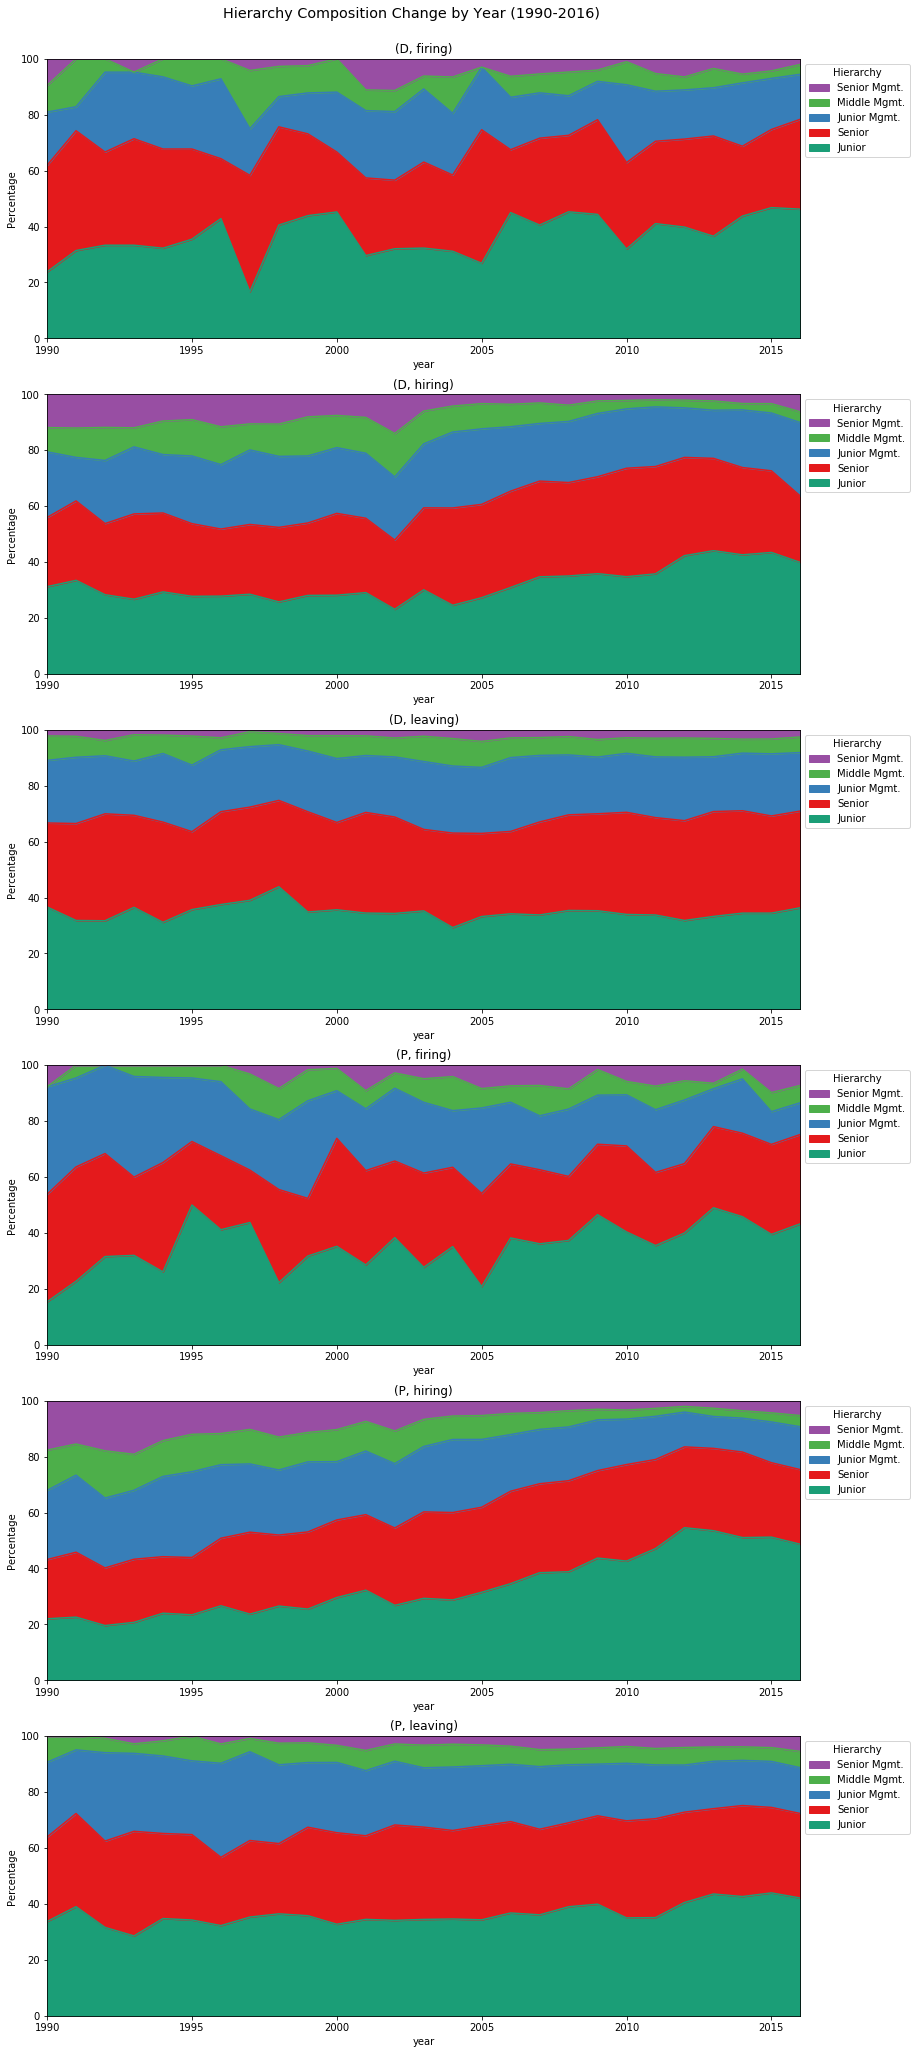

In [35]:
# Hierarchies.
senior_lst = {1:"Junior", 2:"Senior", 3:"Junior Mgmt.", 4:"Middle Mgmt.", 5:"Senior Mgmt."}
colormap_unif = {int(idx+1):clr for idx, clr in zip(
    range(len(senior_lst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Hierarchy Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_top1k_jobs_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','senior0']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.senior0]].assign(count = 1).pivot_table(
        index='year', columns='senior0', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[int(float(idx))] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [senior_lst[int(float(x))] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Hierarchy"
    )
plt.show()